In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Import data

Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

This data comes from Kaggle competition, "CareerCon 2019 - Help Navigate Robots"

We'll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

Researcher’ve collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity. Succeed and we'll help improve the navigation of robots without assistance across many different surfaces, so they won’t fall down on the job.

The data has been collected by Heikki Huttunen and Francesco Lomio from the Department of Signal Processing and Damoon Mohamadi, Kaan Celikbilek, Pedram Ghazi and Reza Ghabcheloo from the Department of Automation and Mechanical Engineering both from Tampere University, Finland.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/NU/MSDS458/career-con-2019/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/NU/MSDS458/career-con-2019/y_train.csv')
test = pd.read_csv('/content/drive/MyDrive/NU/MSDS458/career-con-2019/sample_submission.csv')
sub = pd.read_csv('/content/drive/MyDrive/NU/MSDS458/career-con-2019/sample_submission.csv')

# EDA

we have data about small mobile robot driving over different floor surfaces. We need to predict the floor type based on robot's sensor data.

The data is composed of 487680 records with 13 columns.

In [ ]:
train.shape

(487680, 13)

The input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns.

- row_id: The ID for this row.
- series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.
- measurement_number: Measurement number within the series.

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:
- orientation_X
- orientation_Y
- orientation_Z
- orientation_W
- angular_velocity_X
- angular_velocity_Y
- angular_velocity_Z
- linear_acceleration_X
- linear_acceleration_Y
- linear_acceleration_Z

In [ ]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


There are 3810 series in data. 128 measurements in each time-series with data on robot orientation, angular velocity and linear acceleration

In [ ]:
train['series_id'].nunique()

3810

### Target information

Target have 1 class per series, so we can aggregate train and test data on series. We have 9 unique classes as a target

In [ ]:
y['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [ ]:
len(y['surface'].unique())

9

Measurements are taken in groups (73 groups in total), so this data could be used in validation. We'll try it later.

In [ ]:
y['group_id'].nunique()

73

Distribution of target values

In [ ]:
y['surface'].value_counts().reset_index().rename(columns={'index': 'target'})

,target,surface
0,concrete,779
1,soft_pvc,732
2,wood,607
3,tiled,514
4,fine_concrete,363
5,hard_tiles_large_space,308
6,soft_tiles,297
7,carpet,189
8,hard_tiles,21


In [ ]:
df = y['surface'].value_counts().reset_index().rename(columns={'index': 'target'})

We have a serious disbalance, some classes exist only in several series.

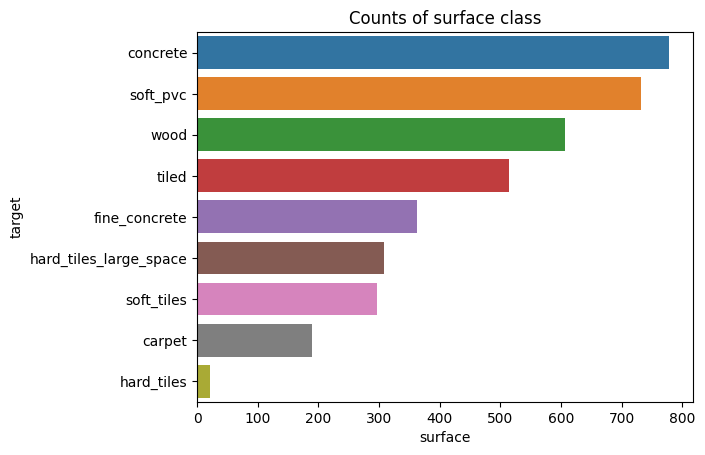

In [ ]:
sns.barplot(x=df['surface'], y=df['target'])
plt.title('Counts of surface class')
plt.show()

### Orientation information

There are 4 coordinates: X, Y, Z, W.

Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. Quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Velocity and acceleration have normal distribution, orientation features seem to have normalized values (using tanh function).

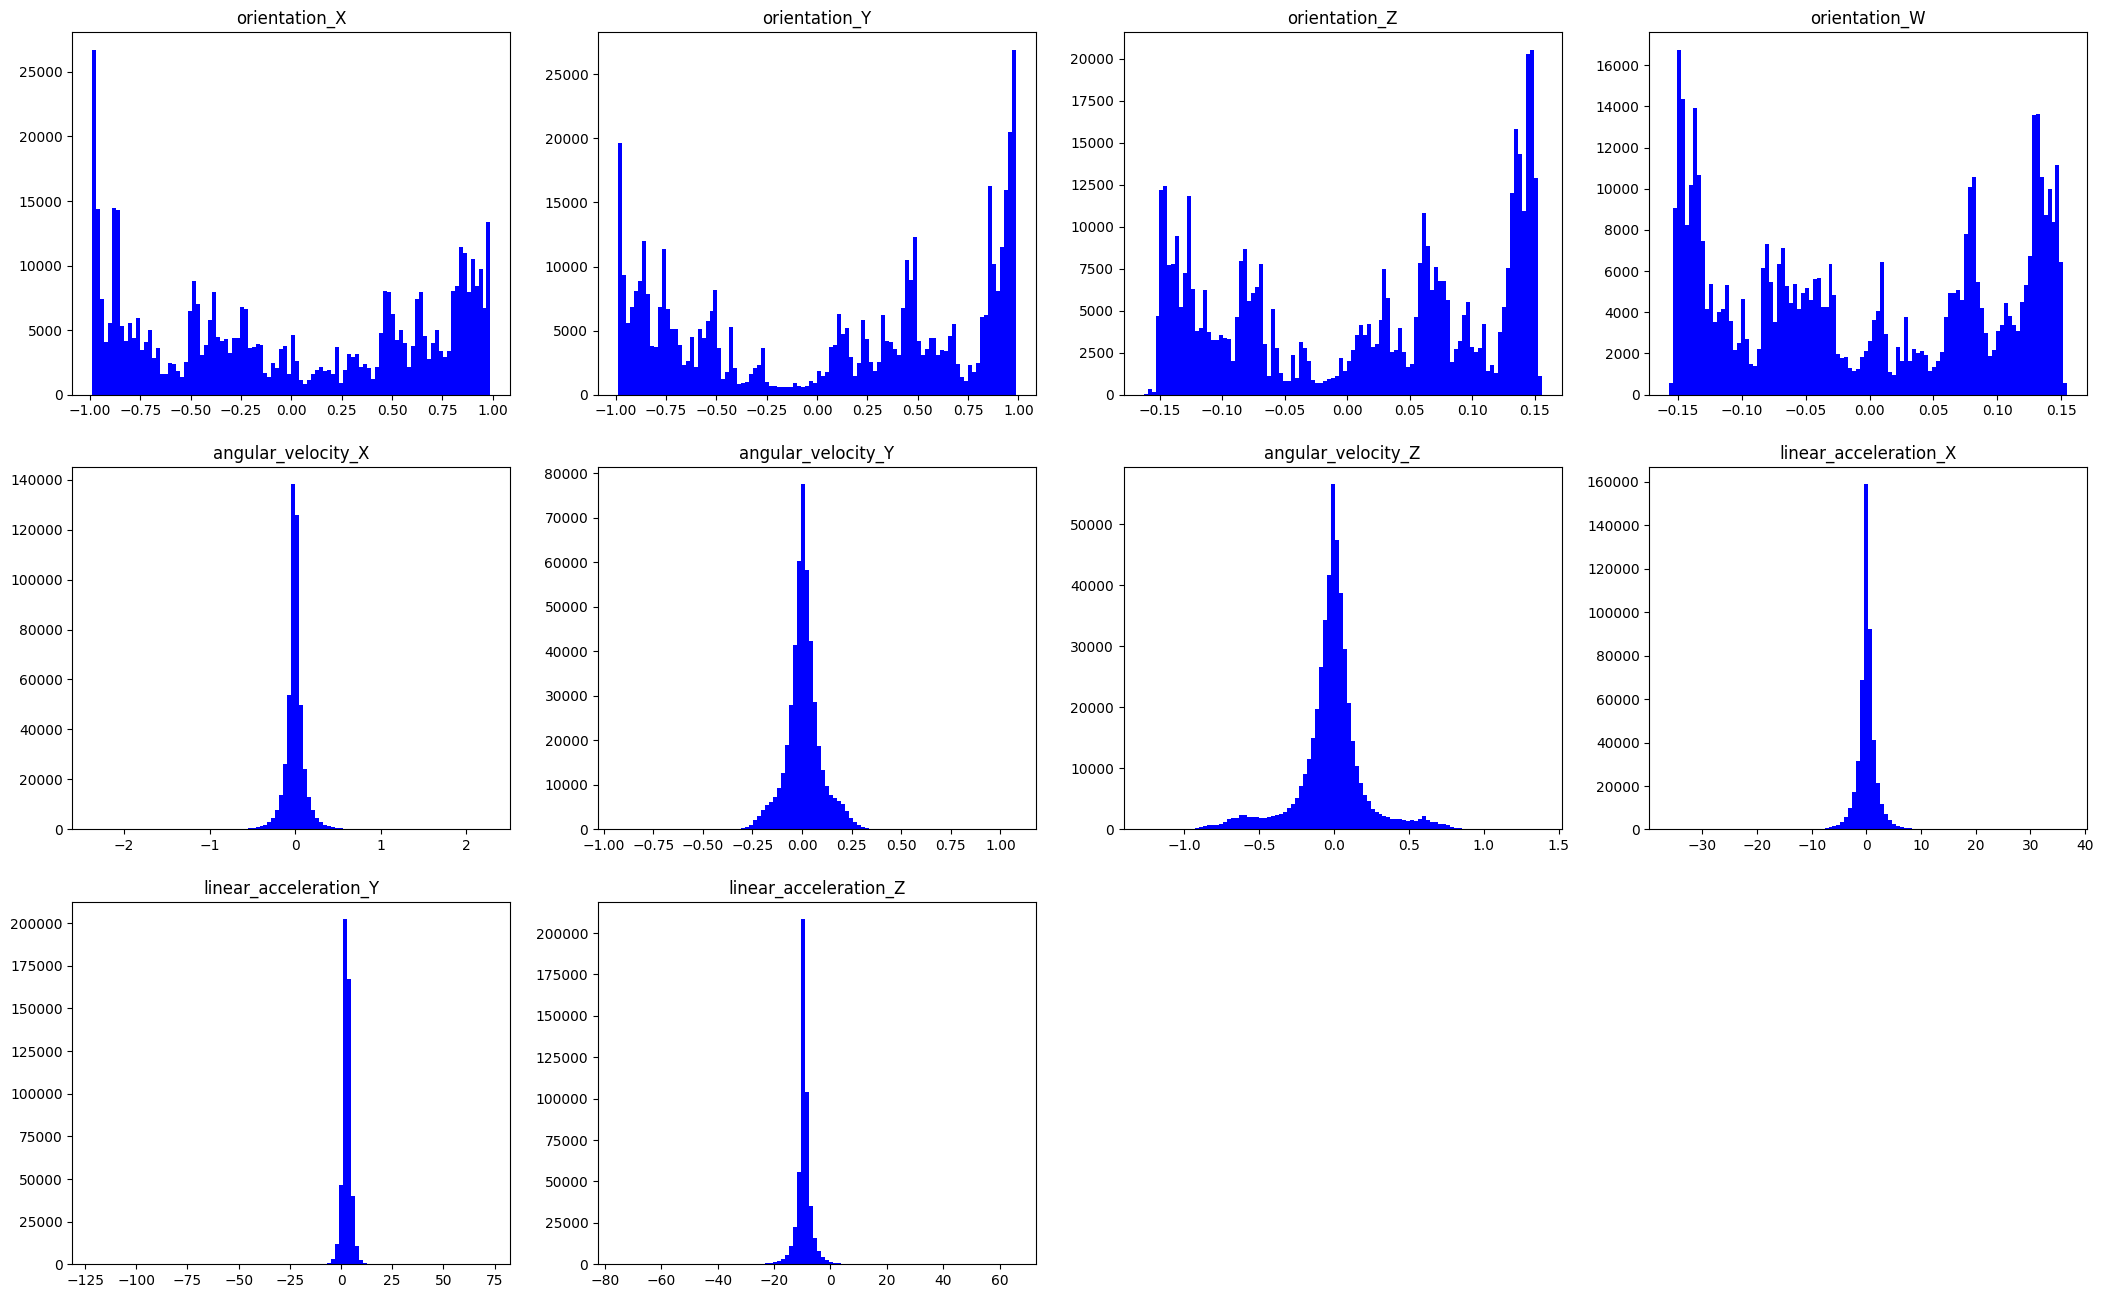

In [ ]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], color='blue', bins=100)
    plt.title(col)

Let's have a look at the values of features in a single time-series

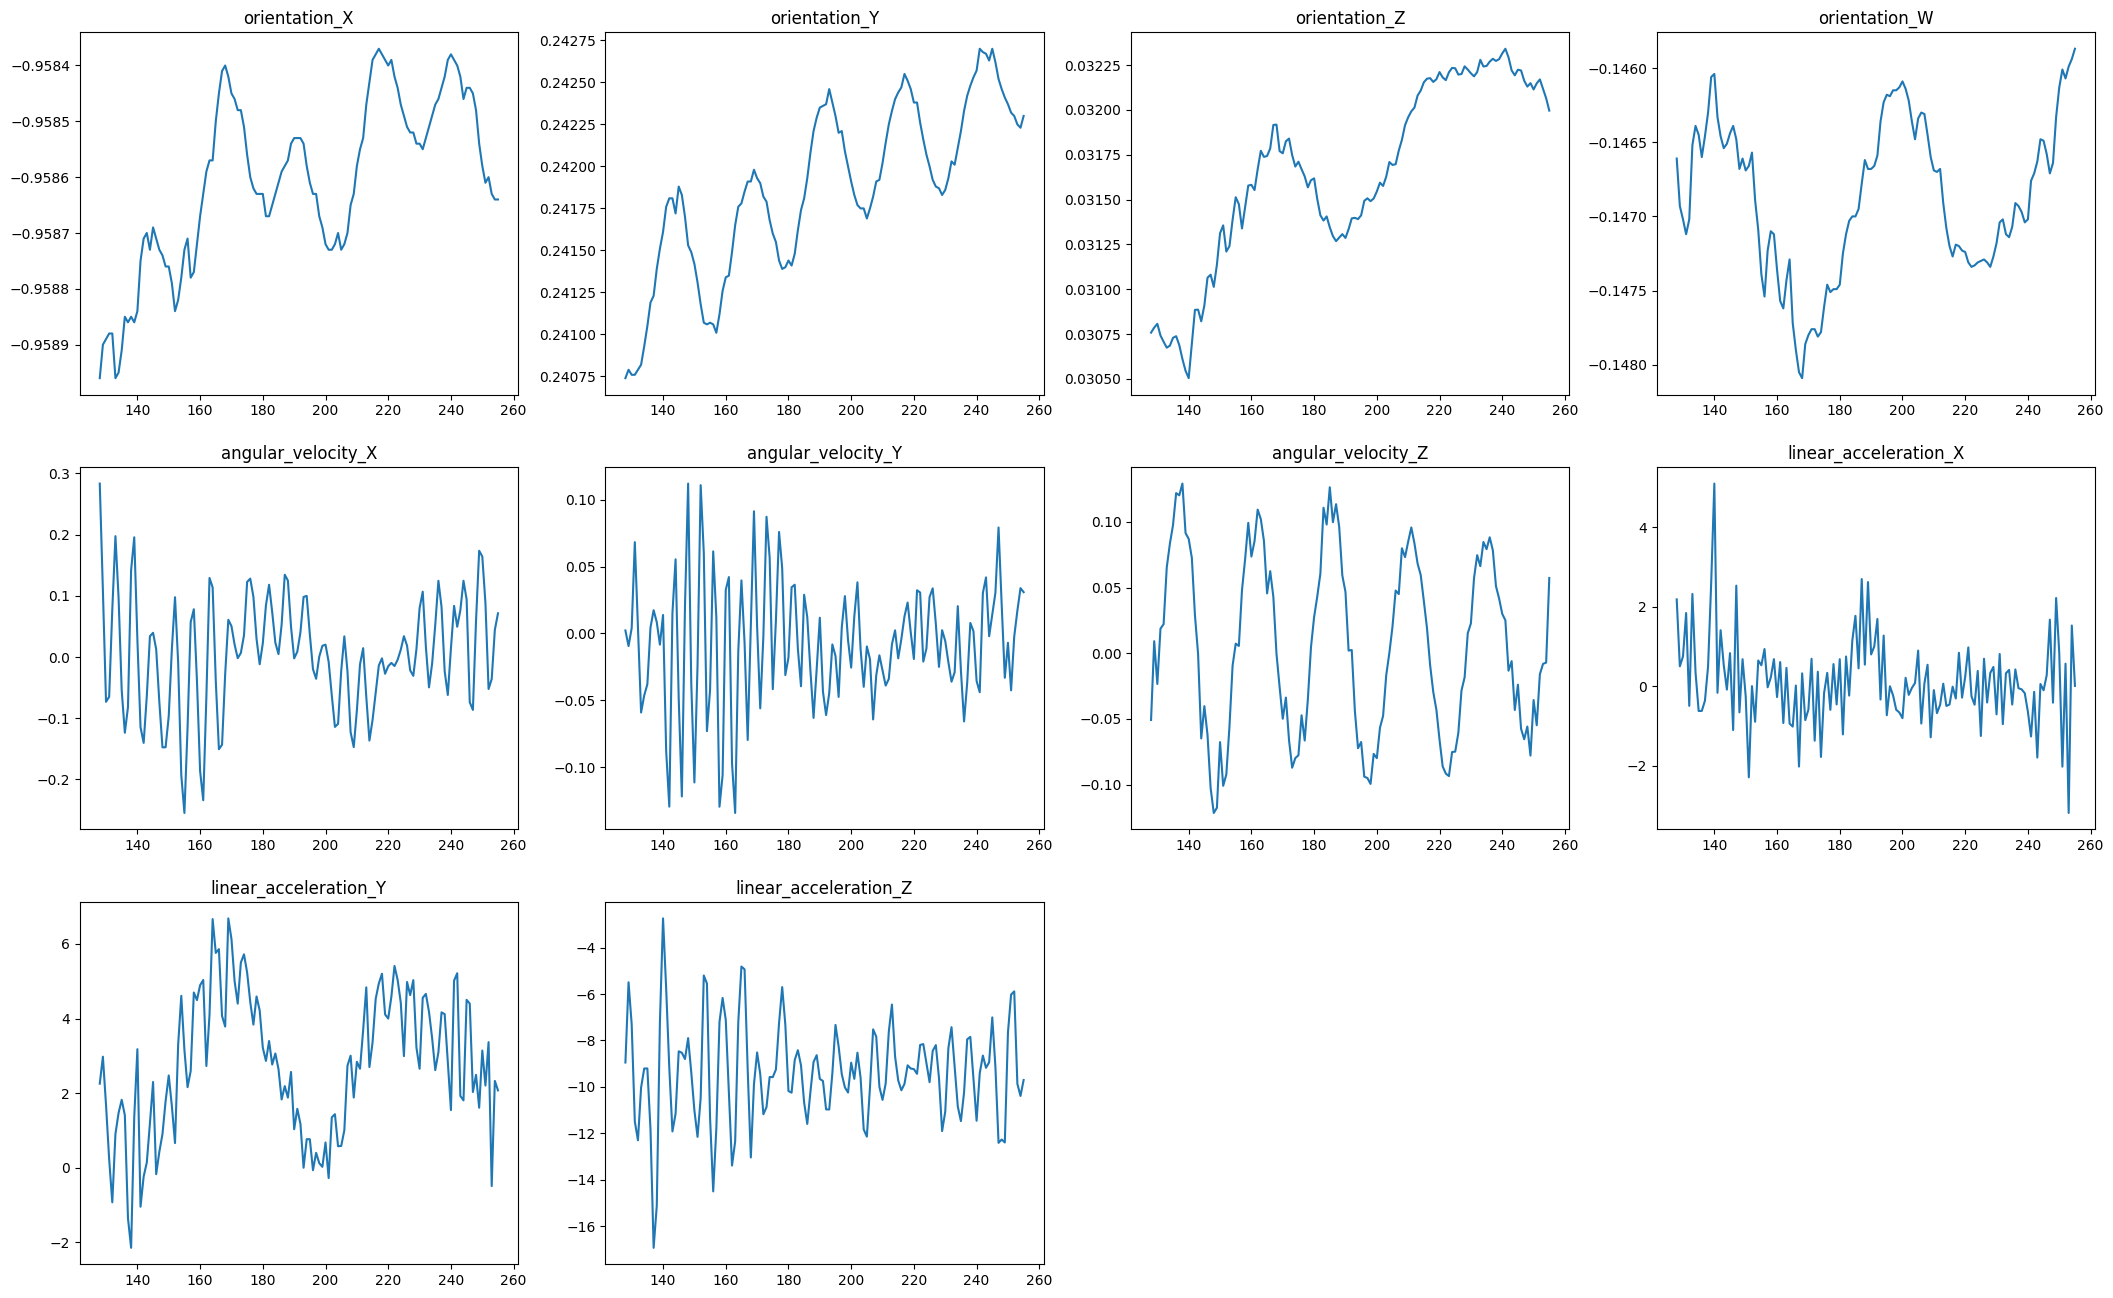

In [ ]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 1, col])
    plt.title(col)

<ipython-input-14-2be4030e1395>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ttc[feature], hist=False,label=clas)
<ipython-input-14-2be4030e1395>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ttc[feature], hist=False,label=clas)
<ipython-input-14-2be4030e1395>:15: User

<Figure size 640x480 with 0 Axes>

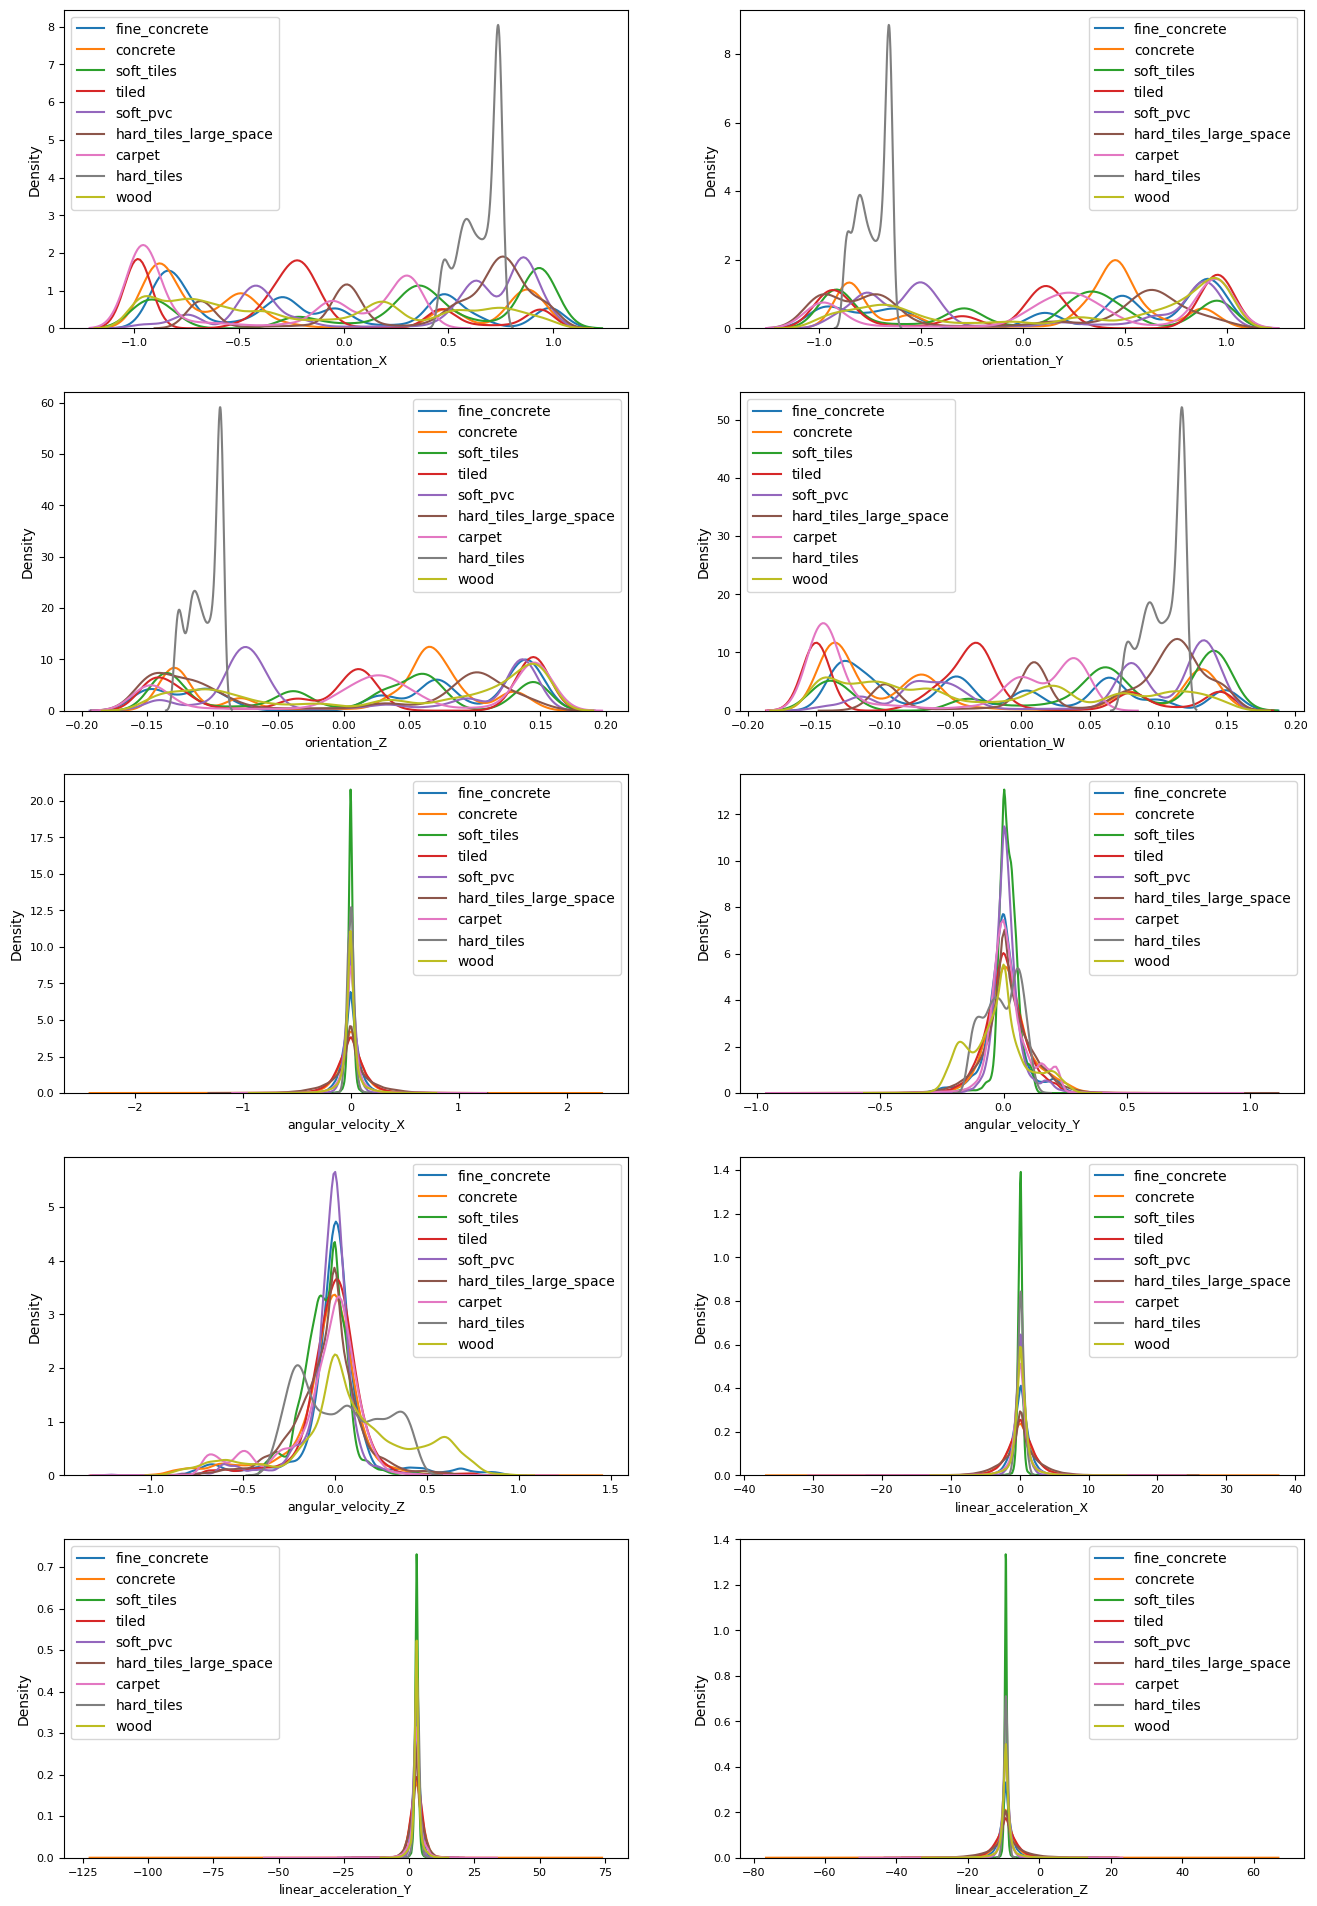

In [ ]:
classes = (y['surface'].value_counts()).index
tt = train.merge(y, on='series_id', how='inner')
features = train.columns.values[3:13]
classes = y['surface'].unique()

# sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5,2,figsize=(16,24))
i = 0
for feature in features:
    i += 1
    plt.subplot(5,2,i)
    for clas in classes:
        ttc = tt[tt['surface']==clas]
        sns.distplot(ttc[feature], hist=False,label=clas)
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.legend()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
plt.show();

### Target feature

Let's show now the distribution of target feature - surface and group_id.

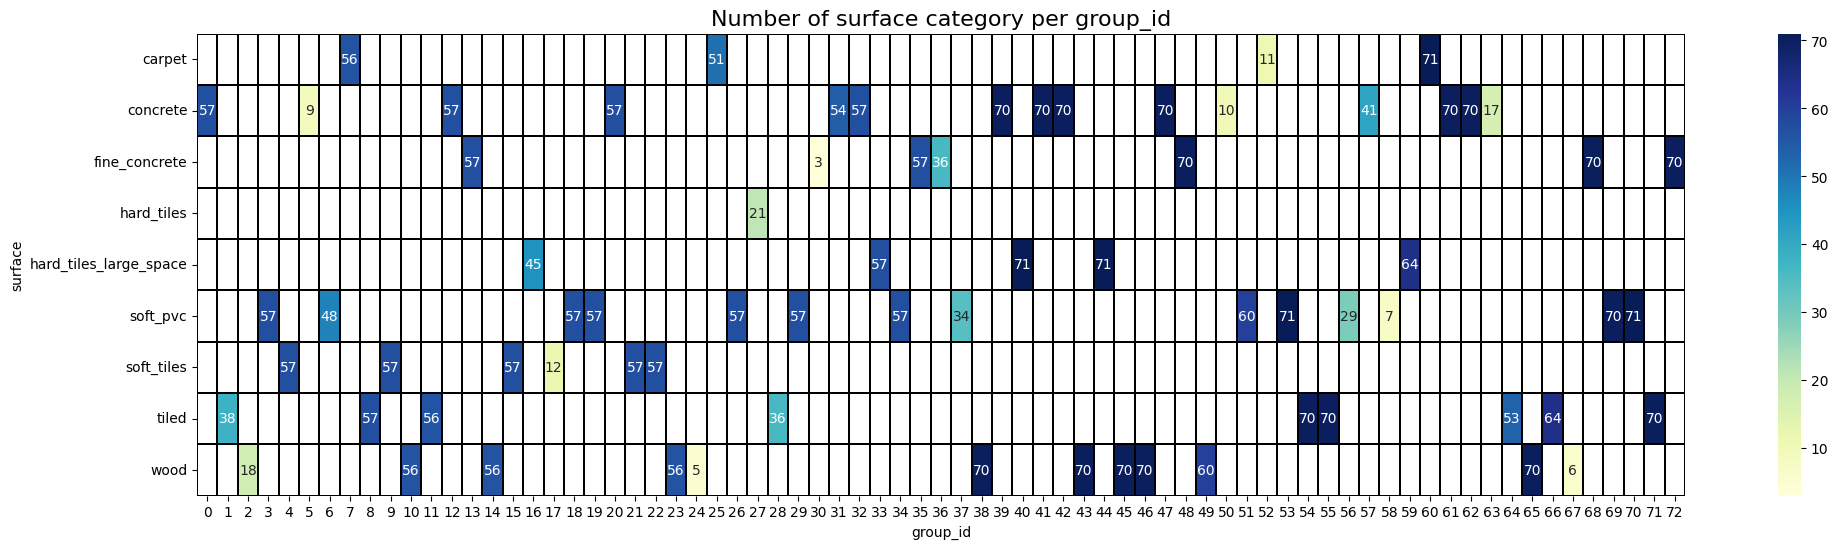

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24,6))
tmp = pd.DataFrame(y.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

In [ ]:
y[y['series_id'] == 1]

,series_id,group_id,surface
1,1,31,concrete


In [ ]:
#y[y['surface'] == "hard_tiles"]
y[y['series_id'] == 27]

,series_id,group_id,surface
27,27,27,hard_tiles


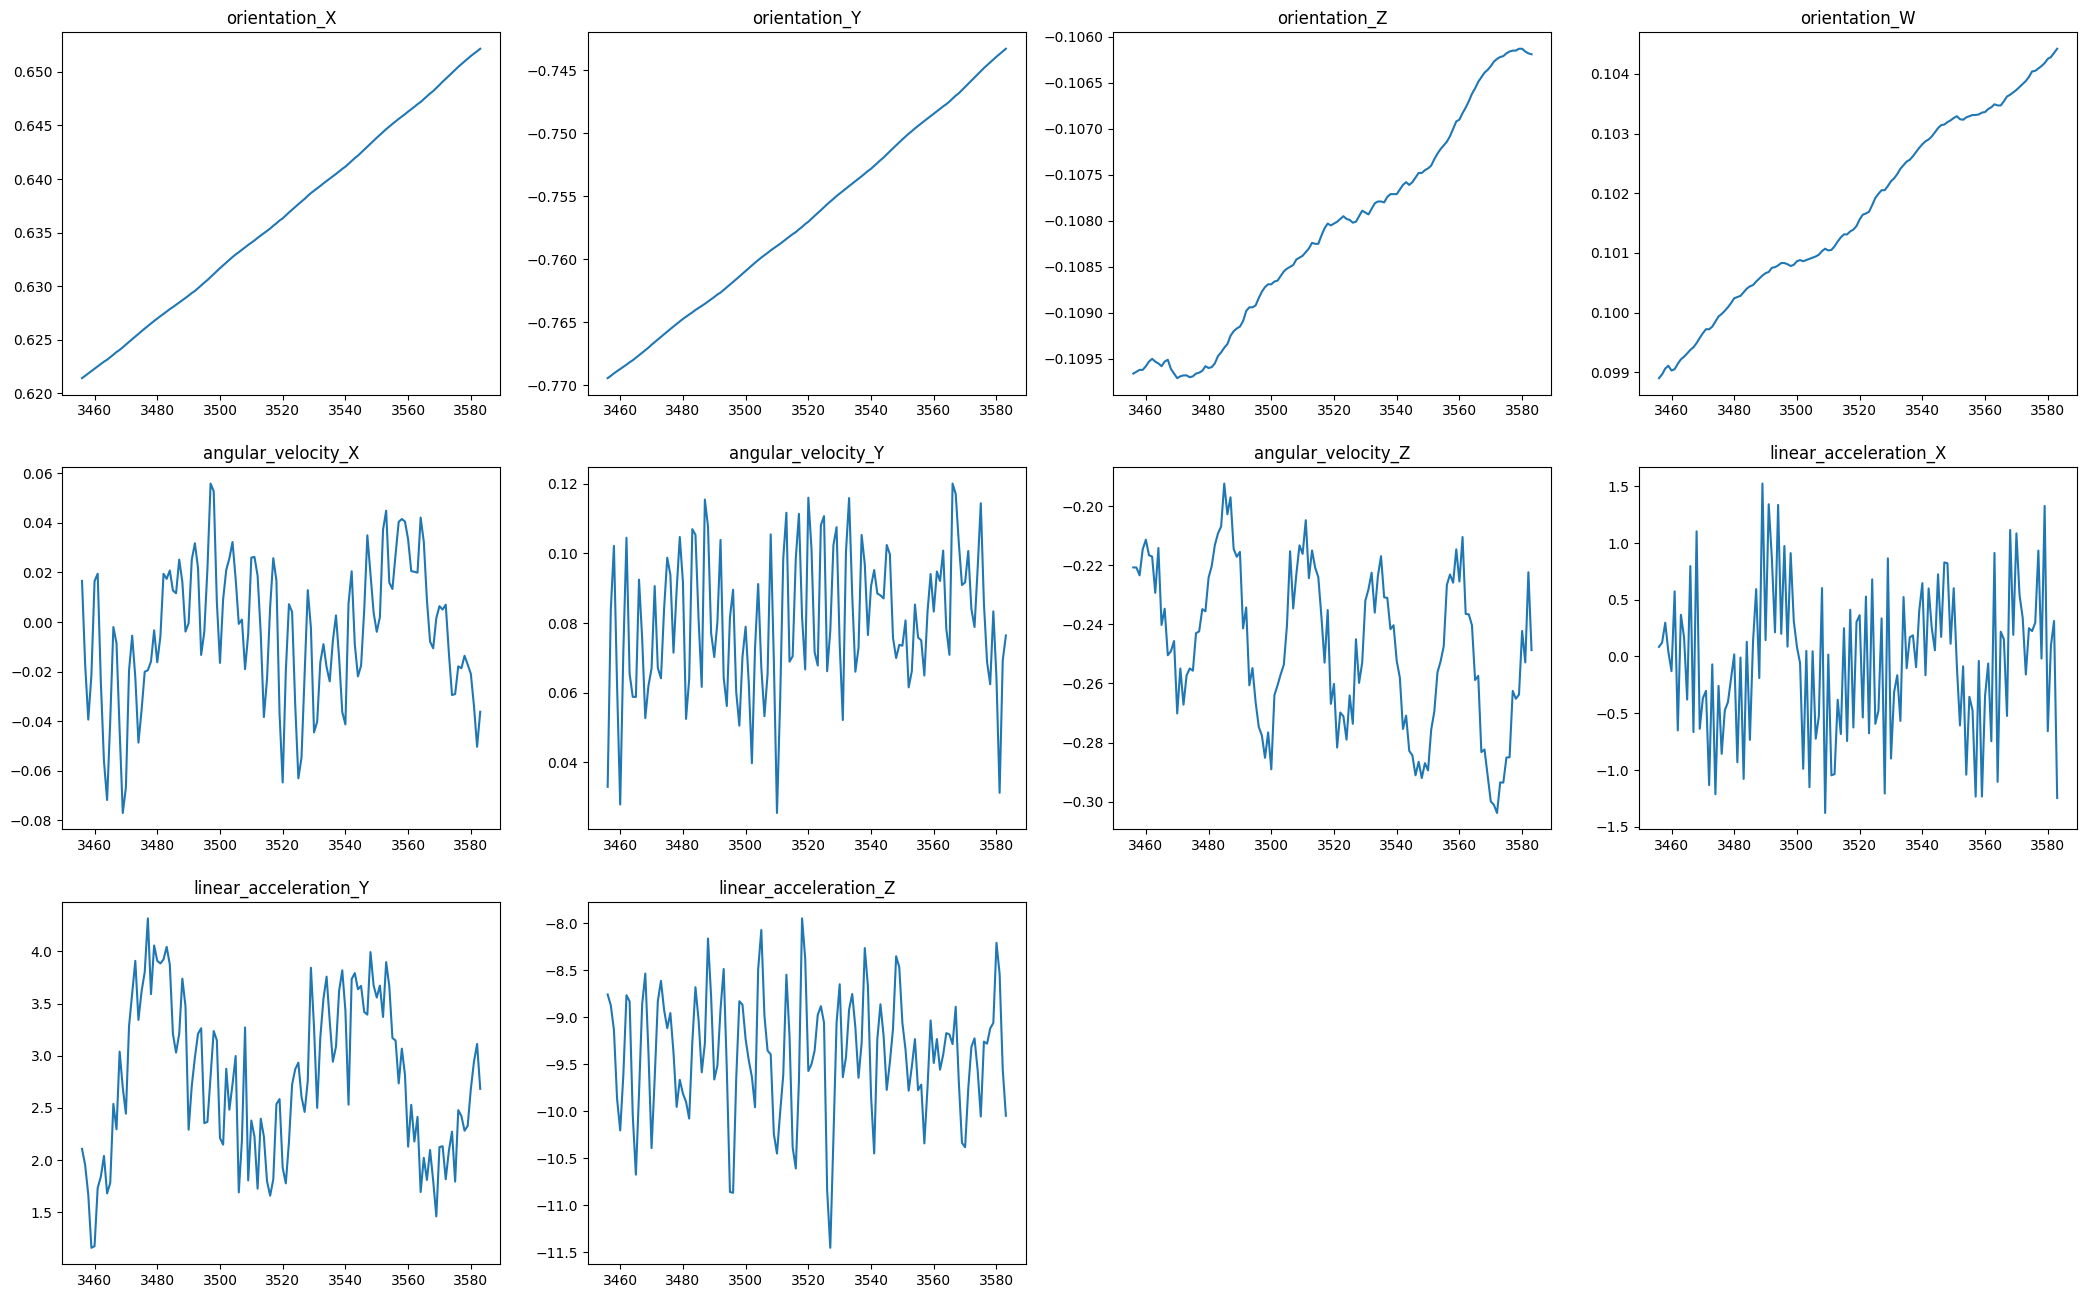

In [ ]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 27, col])
    plt.title(col)

### Feature Correlation

Very strong correlation (1.0) is between orientation_X and orientation_W and between orientation_Z and orientation_Y.
There is a strong inverse correlation (-0.8) between angular_velocity_Z and angular_velocity_Y.
Also, there is a medium positive correlation (0.4) between linear_acceleration_Y and linear_acceleration_Z.

<Axes: >

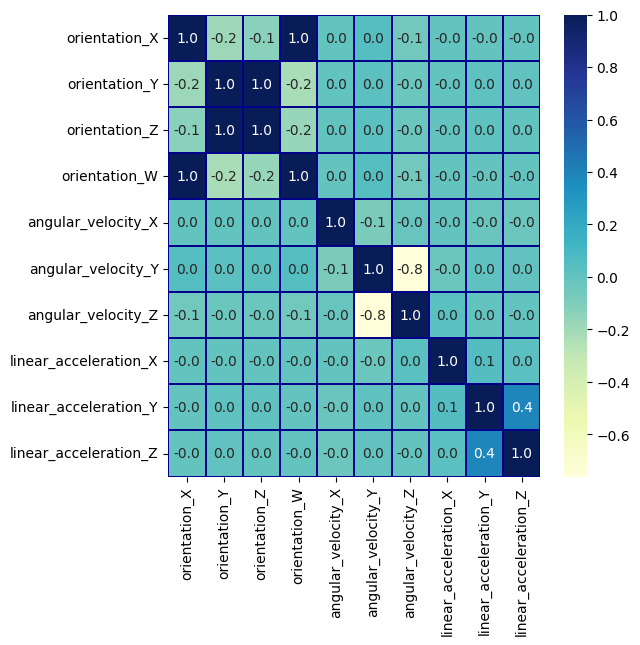

In [ ]:
f,ax = plt.subplots(figsize=(6,6))
m = train.iloc[:,3:].corr()
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt= '.1f',ax=ax)

### Bivariate analysis

In [ ]:
#Function to calculate the norm of a three element vector
def vector_norm(x,y,z,df):
    return np.sqrt(df[x]**2 + df[y]**2 + df[z]**2)

In [ ]:
train['angular_velocity_norm'] =vector_norm('angular_velocity_X',
                                                'angular_velocity_Y',
                                                'angular_velocity_Z',train)

train['linear_acceleration_norm'] =vector_norm('linear_acceleration_X',
                                                'linear_acceleration_Y',
                                                'linear_acceleration_Z',train)

In [ ]:
new_df = train.groupby('series_id')['angular_velocity_norm','linear_acceleration_norm'].mean()
new_df = pd.DataFrame(new_df).reset_index()
new_df.columns = ['serie_id','avg_velocity','avg_acceleration']
new_df['surface'] = y.surface
new_df['group_id'] = y.group_id

<ipython-input-36-97070d43b185>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = train.groupby('series_id')['angular_velocity_norm','linear_acceleration_norm'].mean()


In [ ]:
new_df.head(3)

,serie_id,avg_velocity,avg_acceleration,surface,group_id
0,0,0.057668,9.939676,fine_concrete,13
1,1,0.111790,10.082444,concrete,31
2,2,0.071090,10.035741,concrete,20


analyze if there are differences between average velocity depending on the surface and on the recording session(group_id)

It looks there is a slight difference. It is logic as a robot is thought to reach higher speed on wood than on carpet.

Text(0.5, 1.0, 'avg_velocity vs surface')

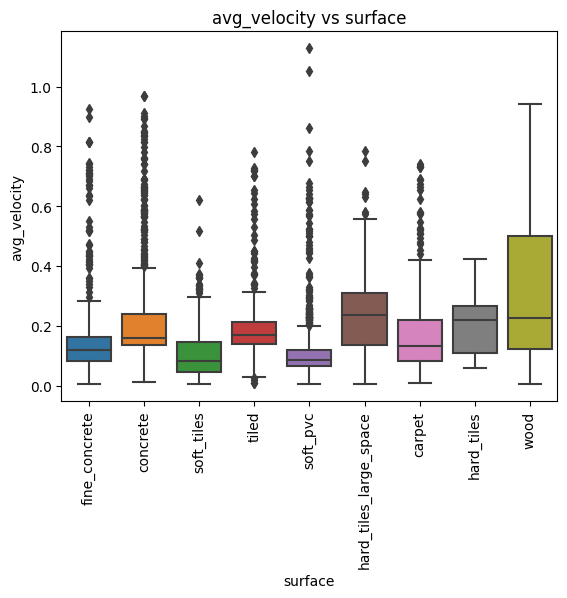

In [ ]:
sns.boxplot(x='surface',y='avg_velocity',data=new_df)
plt.xticks(rotation=90)
plt.title('avg_velocity vs surface')

We can appreciate the same for average acceleration.

Text(0.5, 1.0, 'Avg_acceleration vs Surface')

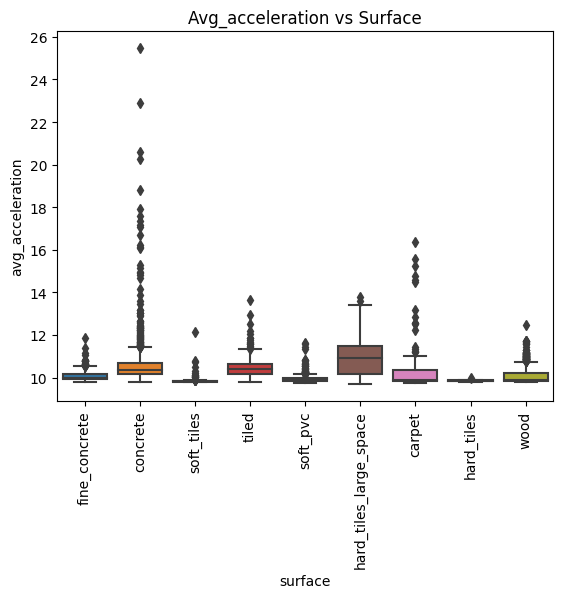

In [ ]:
sns.boxplot(x='surface',y='avg_acceleration',data=new_df)
plt.xticks(rotation=90)
plt.title('Avg_acceleration vs Surface')

In [ ]:
len(train["series_id"].unique())

3810